<a href="https://colab.research.google.com/github/sculd/sandbox_gym/blob/master/move_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct  4 17:19:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    719MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
DEFAULT_SEED = 100

def hash_with_seed(value: str, seed: int):
    print('value', value)
    hash=0
    for ch in value:
        hash = (hash * (seed * 17) ^ ord(ch) * seed) & 0xFFFFFFFF
    return hash


def test_split_hash_value(symbols, test_split, seed=None):
    if not seed:
        seed = DEFAULT_SEED
    symbols_with_hash = [(hash_with_seed(symbol, seed), symbol,) for symbol in symbols]
    symbols_with_hash.sort()

    train_size = int(len(symbols_with_hash) * (1.0 - test_split))
    return symbols_with_hash[train_size][0]

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

dataframe = pd.read_csv('data_ml.csv')

#dataframe = dataframe[['stepChange','minDrop','maxJump','changeSinceMinDrop','changeSinceMaxJump','changePT6H','bandwidthPT2H2','bandPercentPT2H2','moneyFlowPT40M','return_jump_30m']]
dataframe = dataframe.dropna()

dataframe['target'] = dataframe['return_jump_30m'].astype(int)
dataframe = dataframe.drop('return_jump_30m', axis=1)

val_dataframe = dataframe.iloc[int(len(dataframe) * 0.6):,:]
train_dataframe = dataframe.iloc[:int(len(dataframe) * 0.6),:]

#val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
#train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Using 587549 samples for training and 391700 for validation
Input: {'epochSeconds': <tf.Tensor: shape=(), dtype=int64, numpy=1663404360>, 'market': <tf.Tensor: shape=(), dtype=string, numpy=b'binance'>, 'symbol': <tf.Tensor: shape=(), dtype=string, numpy=b'BNBDOWNUSDT'>, 'stepChange': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'priceAtAnalysis': <tf.Tensor: shape=(), dtype=float64, numpy=0.04325>, 'minDrop': <tf.Tensor: shape=(), dtype=float64, numpy=-0.0>, 'maxJump': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'changeSinceMinDrop': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'changeSinceMaxJump': <tf.Tensor: shape=(), dtype=float64, numpy=-0.0>, 'normalizedPricePT3H': <tf.Tensor: shape=(), dtype=float64, numpy=-0.78>, 'changePT6H': <tf.Tensor: shape=(), dtype=float64, numpy=-0.0>, 'rsiPT3H': <tf.Tensor: shape=(), dtype=float64, numpy=48.21>, 'bandwidthPT2H2': <tf.Tensor: shape=(), dtype=float64, numpy=0.01>, 'bandPercentPT2H2': <tf.Tensor: shape=(), dtype=float64, nump

In [ ]:
weight_for_0 = 1.0 / len(dataframe[dataframe.target == 0])
weight_for_1 = 1.0 / len(dataframe[dataframe.target == 1])

In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
from sklearn.metrics import roc_curve

def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


"""
## Build a model

With this done, we can create our end-to-end model:
"""

# ['stepChange','minDrop','maxJump','changeSinceMinDrop','changeSinceMaxJump','changePT6H','bandwidthPT2H2','bandPercentPT2H2','moneyFlowPT40M','return_jump_30m']
# Categorical features encoded as integers
step_change = keras.Input(shape=(1,), name="stepChange")
min_drop = keras.Input(shape=(1,), name="minDrop")
max_jump = keras.Input(shape=(1,), name="maxJump")
change_since_min_drop = keras.Input(shape=(1,), name="changeSinceMinDrop")
change_since_max_jump = keras.Input(shape=(1,), name="changeSinceMaxJump")
change_6h = keras.Input(shape=(1,), name="changePT6H")
bandwitdh_2h = keras.Input(shape=(1,), name="bandwidthPT2H2")
band_percent_2h = keras.Input(shape=(1,), name="bandPercentPT2H2")
money_flow_40m = keras.Input(shape=(1,), name="moneyFlowPT40M")


all_inputs = [
    #step_change,
    min_drop,
    max_jump,
    change_since_min_drop,
    change_since_max_jump,
    change_6h,
    bandwitdh_2h,
    #band_percent_2h,
    #money_flow_40m,
]

In [ ]:
step_change_encoded = encode_numerical_feature(step_change, "stepChange", train_ds)
min_drop_encoded = encode_numerical_feature(min_drop, "minDrop", train_ds)
max_jump_encoded = encode_numerical_feature(max_jump, "maxJump", train_ds)
change_since_min_drop_encoded = encode_numerical_feature(change_since_min_drop, "changeSinceMinDrop", train_ds)
change_since_max_jump_encoded = encode_numerical_feature(change_since_max_jump, "changeSinceMaxJump", train_ds)
change_6h_encoded = encode_numerical_feature(change_6h, "changePT6H", train_ds)
bandwitdh_2h_encoded = encode_numerical_feature(bandwitdh_2h, "bandwidthPT2H2", train_ds)
band_percent_2h_encoded = encode_numerical_feature(band_percent_2h, "bandPercentPT2H2", train_ds)
money_flow_40m_encoded = encode_numerical_feature(money_flow_40m, "moneyFlowPT40M", train_ds)

all_features = layers.concatenate(
    [
        #step_change_encoded,
        min_drop_encoded,
        max_jump_encoded,
        change_since_min_drop_encoded,
        change_since_max_jump_encoded,
        change_6h_encoded,
        bandwitdh_2h_encoded,
        #band_percent_2h_encoded,
        #money_flow_40m_encoded,
    ]
)

In [ ]:
x = all_features
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)

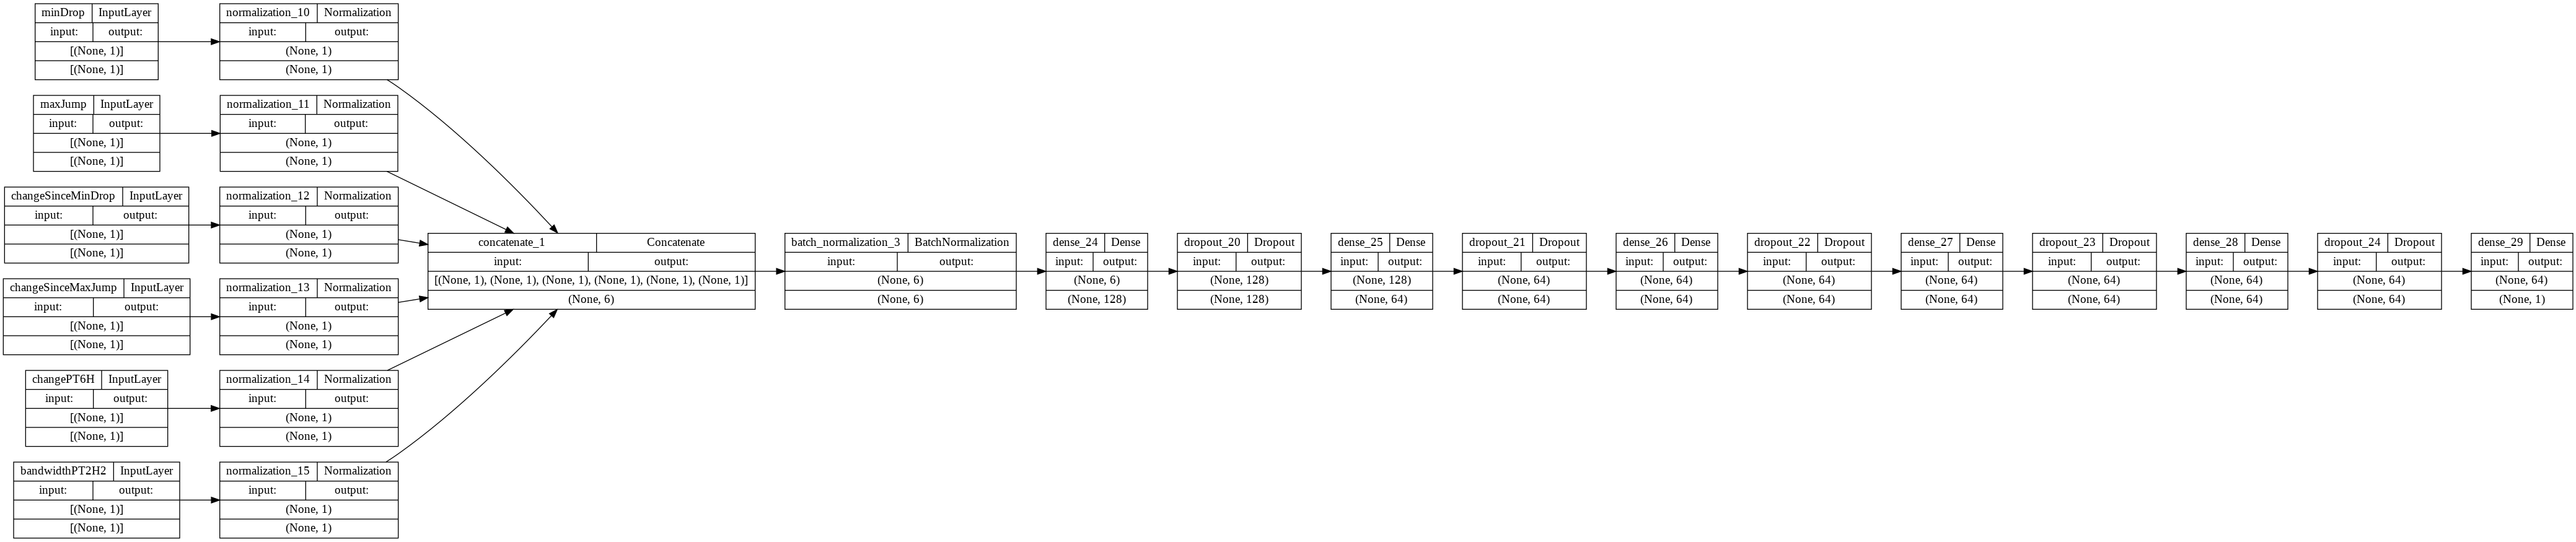

In [ ]:
metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

#model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
print({0: weight_for_0, 1: weight_for_1})
print(weight_for_1/weight_for_0)

{0: 1.0221102897887093e-06, 1: 0.0011350737797956867}
1110.5198637911465


In [ ]:
model.fit(train_ds, epochs=4, validation_data=val_ds
          , class_weight={0: 1.0, 1: weight_for_1/weight_for_0}
)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['epochSeconds', 'market', 'symbol', 'stepChange', 'priceAtAnalysis', 'normalizedPricePT3H', 'rsiPT3H', 'bandPercentPT2H2', 'moneyFlowPT40M', 'return_jump_10m', 'return_drop_10m', 'return_drop_30m'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2296/2296 [==============================] - 37s 14ms/step - loss: 6.8916 - auc: 0.7721 - fn: 94.0000 - fp: 138397.0000 - tn: 448859.0000 - tp: 199.0000 - precision: 0.0014 - recall: 0.6792 - val_loss: 0.1263 - val_auc: 0.7286 - val_fn: 313.0000 - val_fp: 24762.0000 - val_tn: 366350.0000 - val_tp: 275.0000 - val_precision: 0.0110 - val_recall: 0.4677
Epoch 2/4
2296/2296 [==============================] - 34s 14ms/step - loss: 1.2944 - auc: 0.6887 - fn: 185.0000 - fp: 86317.0000 - tn: 500939.0000 - tp: 108.0000 - precision: 0.0012 - recall: 0.3686 - val_loss: 0.4488 - val_auc: 0.5000 - val_fn: 588.0000 - val_fp: 0.0000e+00 - val_tn: 391112.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/4
2296/2296 [==============================] - 35s 14ms/step - loss: 1.2381 - auc: 0.4961 - fn: 289.0000 - fp: 6554.0000 - tn: 580702.0000 - tp: 4.0000 - precision: 6.0994e-04 - recall: 0.0137 - val_loss: 0.1115 - val_auc: 0.5083 - val_fn: 588.0000 - val_fp: 0.0000e

In [ ]:
'''
sample = {
    "stepChange": 0.0,
    "minDrop": -0.03,
    "maxJump": 0.01,
    "changeSinceMinDrop": 0.01,
    "changeSinceMaxJump": 0.0,
    "changePT6H": 0.0,
    "bandwidthPT2H2": 0.0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
print(
    "This particular patient had a {p} percent probability of having 1, as evaluated by our model: {pred}.".format(p = round(100 * predictions[0][0], 1), pred = predictions)
)
'''

'\nsample = {\n    "stepChange": 0.0,\n    "minDrop": -0.03,\n    "maxJump": 0.01,\n    "changeSinceMinDrop": 0.01,\n    "changeSinceMaxJump": 0.0,\n    "changePT6H": 0.0,\n    "bandwidthPT2H2": 0.0,\n}\n\ninput_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}\npredictions = model.predict(input_dict)\nprint(\n    "This particular patient had a {p} percent probability of having 1, as evaluated by our model: {pred}.".format(p = round(100 * predictions[0][0], 1), pred = predictions)\n)\n'

In [ ]:
val_preds = model.predict(val_ds).ravel()

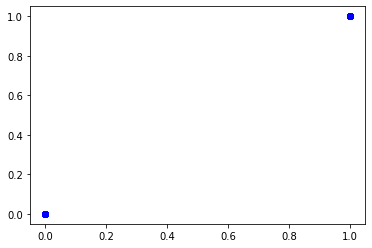

In [ ]:
import matplotlib.pyplot as plt
positives = val_preds[np.where(val_dataframe.target.values == 1)]
negatives = val_preds[np.where(val_dataframe.target.values == 0)]
tp = positives.shape[0]
tn = negatives.shape[0]
x, y = [], []
th = 1.01
while th >= -0.02:
    tpr = np.where(positives >= th)[0].shape[0] / tp
    fpr = np.where(negatives >= th)[0].shape[0] / tn
    x.append(fpr)
    y.append(tpr)
    th -= 0.01
plt.plot(x, y, 'bo')

In [ ]:
np.where(negatives >= 0.00)[0].shape[0] / tn

1.0

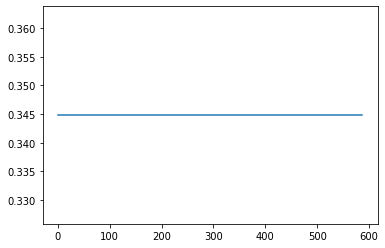

In [ ]:
plt.plot(val_preds[np.where(val_dataframe.target.values == 1)])

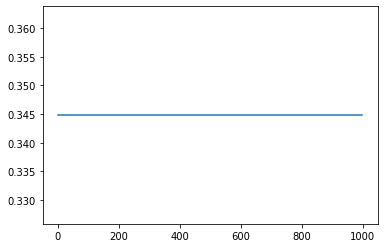

In [ ]:
plt.plot(val_preds[np.where(val_dataframe.target.values == 0)][2000:3000])

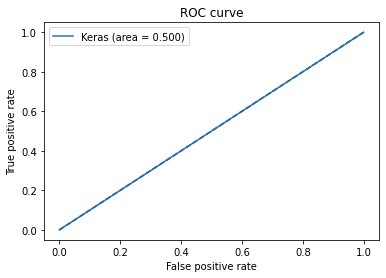

In [ ]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(val_dataframe.target.values, val_preds)
auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model.fit(train_ds, epochs=3, validation_data=val_ds
          , class_weight={0: 1.0, 1: 10 * weight_for_1/weight_for_0}
)

Epoch 1/3
2296/2296 [==============================] - 35s 14ms/step - loss: 2.9579 - auc: 0.4603 - fn: 7.0000 - fp: 571398.0000 - tn: 15858.0000 - tp: 286.0000 - precision: 5.0028e-04 - recall: 0.9761 - val_loss: 1.8685 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 391112.0000 - val_tn: 0.0000e+00 - val_tp: 588.0000 - val_precision: 0.0015 - val_recall: 1.0000
Epoch 2/3
2296/2296 [==============================] - 35s 14ms/step - loss: 2.8008 - auc: 0.5039 - fn: 0.0000e+00 - fp: 587254.0000 - tn: 2.0000 - tp: 293.0000 - precision: 4.9868e-04 - recall: 1.0000 - val_loss: 1.7633 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 391112.0000 - val_tn: 0.0000e+00 - val_tp: 588.0000 - val_precision: 0.0015 - val_recall: 1.0000
Epoch 3/3
2296/2296 [==============================] - 35s 14ms/step - loss: 47.4168 - auc: 0.5429 - fn: 54.0000 - fp: 448654.0000 - tn: 138602.0000 - tp: 239.0000 - precision: 5.3242e-04 - recall: 0.8157 - val_loss: 0.1677 - val_auc: 0.6977 - val_fn: 393.0000 - val

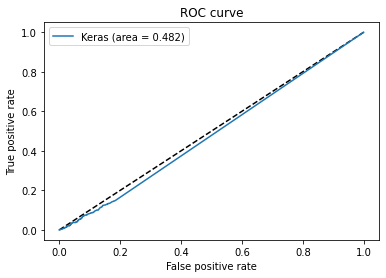

In [ ]:
val_preds = model.predict(val_ds).ravel()
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(val_dataframe.target.values, val_preds)
auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

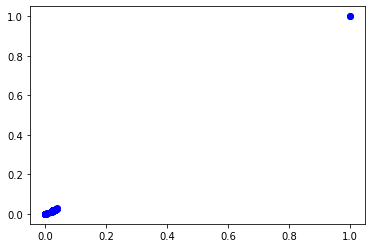

In [ ]:
positives = val_preds[np.where(val_dataframe.target.values == 1)]
negatives = val_preds[np.where(val_dataframe.target.values == 0)]
tp = positives.shape[0]
tn = negatives.shape[0]
x, y = [], []
th = 1.01
while th >= -0.02:
    tpr = np.where(positives >= th)[0].shape[0] / tp
    fpr = np.where(negatives >= th)[0].shape[0] / tn
    x.append(fpr)
    y.append(tpr)
    th -= 0.01
plt.plot(x, y, 'bo')

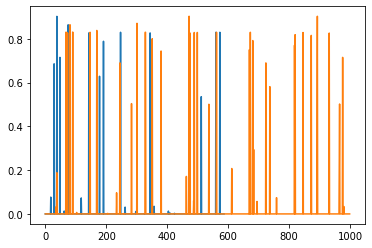

In [ ]:
plt.plot(val_preds[np.where(val_dataframe.target.values == 1)])
plt.plot(val_preds[np.where(val_dataframe.target.values == 0)][2000:3000])

In [ ]:
model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['epochSeconds', 'market', 'symbol', 'stepChange', 'priceAtAnalysis', 'normalizedPricePT3H', 'rsiPT3H', 'bandPercentPT2H2', 'moneyFlowPT40M', 'return_jump_10m', 'return_drop_10m', 'return_drop_30m'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2296/2296 [==============================] - 42s 16ms/step - loss: 0.1729 - auc: 0.5747 - fn: 264.0000 - fp: 20787.0000 - tn: 566469.0000 - tp: 29.0000 - precision: 0.0014 - recall: 0.0990 - val_loss: 0.0456 - val_auc: 0.5000 - val_fn: 588.0000 - val_fp: 0.0000e+00 - val_tn: 391112.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
2296/2296 [==============================] - 39s 16ms/step - loss: 0.0472 - auc: 0.5421 - fn: 282.0000 - fp: 5401.0000 - tn: 581855.0000 - tp: 11.0000 - precision: 0.0020 - recall: 0.0375 - val_loss: 0.0733 - val_auc: 0.5000 - val_fn: 588.0000 - val_fp: 0.0000e+00 - val_tn: 391112.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
2296/2296 [==============================] - 42s 16ms/step - loss: 0.0425 - auc: 0.5589 - fn: 286.0000 - fp: 5184.0000 - tn: 582072.0000 - tp: 7.0000 - precision: 0.0013 - recall: 0.0239 - val_loss: 0.0510 - val_auc: 0.5000 - val_fn: 588.0000 - val_fp: 0.00

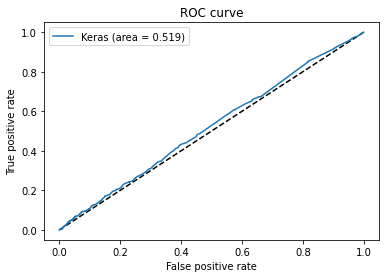

In [ ]:
val_preds = model.predict(val_ds).ravel()
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(val_dataframe.target.values, val_preds)
auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

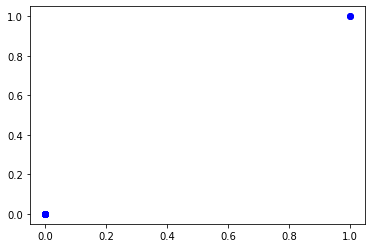

In [ ]:
positives = val_preds[np.where(val_dataframe.target.values == 1)]
negatives = val_preds[np.where(val_dataframe.target.values == 0)]
tp = positives.shape[0]
tn = negatives.shape[0]
x, y = [], []
th = 1.01
while th >= -0.02:
    tpr = np.where(positives >= th)[0].shape[0] / tp
    fpr = np.where(negatives >= th)[0].shape[0] / tn
    x.append(fpr)
    y.append(tpr)
    th -= 0.01
plt.plot(x, y, 'bo')

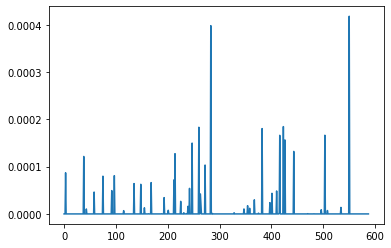

In [ ]:
plt.plot(val_preds[np.where(val_dataframe.target.values == 1)])

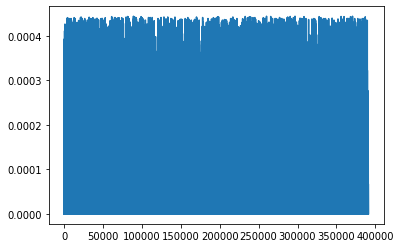

In [ ]:
plt.plot(val_preds[np.where(val_dataframe.target.values == 0)][0000:])

In [ ]:
model.fit(train_ds, epochs=3, validation_data=val_ds
          , class_weight={0: 1.0, 1: 0.1 *  weight_for_1/weight_for_0}
)

Epoch 1/3
2296/2296 [==============================] - 35s 14ms/step - loss: 1.0486 - auc: 0.7802 - fn: 223.0000 - fp: 31916.0000 - tn: 555340.0000 - tp: 70.0000 - precision: 0.0022 - recall: 0.2389 - val_loss: 0.4293 - val_auc: 0.7157 - val_fn: 588.0000 - val_fp: 0.0000e+00 - val_tn: 391112.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
2296/2296 [==============================] - 36s 14ms/step - loss: 1.2001 - auc: 0.6373 - fn: 292.0000 - fp: 1453.0000 - tn: 585803.0000 - tp: 1.0000 - precision: 6.8776e-04 - recall: 0.0034 - val_loss: 0.0850 - val_auc: 0.4913 - val_fn: 588.0000 - val_fp: 0.0000e+00 - val_tn: 391112.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
2296/2296 [==============================] - 35s 14ms/step - loss: 0.2926 - auc: 0.6108 - fn: 292.0000 - fp: 196.0000 - tn: 587060.0000 - tp: 1.0000 - precision: 0.0051 - recall: 0.0034 - val_loss: 0.0681 - val_auc: 0.6900 - val_fn: 588.0000 - 

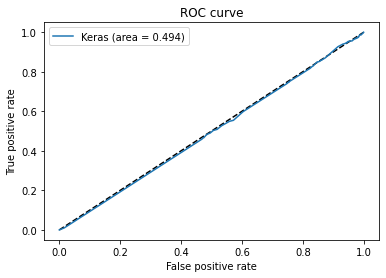

In [ ]:
val_preds = model.predict(val_ds).ravel()
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(val_dataframe.target.values, val_preds)
auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

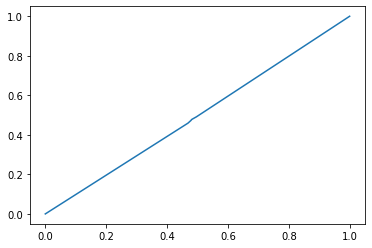

In [ ]:
positives = val_preds[np.where(val_dataframe.target.values == 1)]
negatives = val_preds[np.where(val_dataframe.target.values == 0)]
tp = positives.shape[0]
tn = negatives.shape[0]
x, y = [], []
th = 1.01
while th >= -0.02:
    tpr = np.where(positives >= th)[0].shape[0] / tp
    fpr = np.where(negatives >= th)[0].shape[0] / tn
    x.append(fpr)
    y.append(tpr)
    th -= 0.01
plt.plot(x, y)

In [ ]:
negatives.shape

(391112,)

In [ ]:
np.where(val_dataframe.target.values == 0)[0].shape

(391112,)

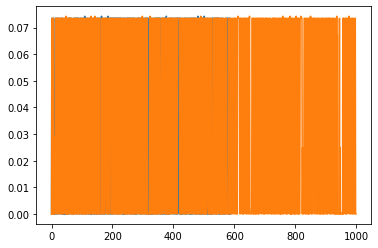

In [ ]:
plt.plot(val_preds[np.where(val_dataframe.target.values == 1)])
plt.plot(val_preds[np.where(val_dataframe.target.values == 0)][2000:3000])